
GradientBoosting Performance:
  R^2 Score:           0.9845
  Mean Squared Error:  71.0320
  Mean Absolute Error: 6.0075
  PHM08 Score (sum):   4804.5045
  PHM08 Score (avg):   1.1642

XGBoost Performance:
  R^2 Score:           0.9825
  Mean Squared Error:  79.7548
  Mean Absolute Error: 6.8220
  PHM08 Score (sum):   5054.8245
  PHM08 Score (avg):   1.2248

Ensemble Performance:
  R^2 Score:           0.9868
  Mean Squared Error:  60.1903
  Mean Absolute Error: 5.7569
  PHM08 Score (sum):   3951.9079
  PHM08 Score (avg):   0.9576
Computing SHAP (fast) for GradientBoosting...


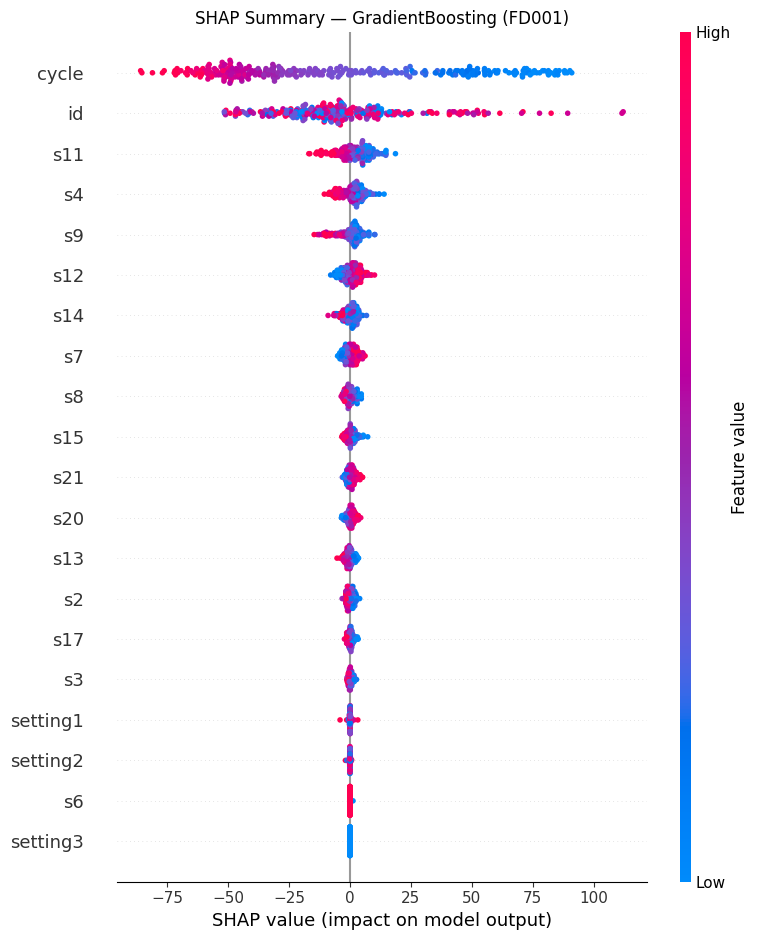

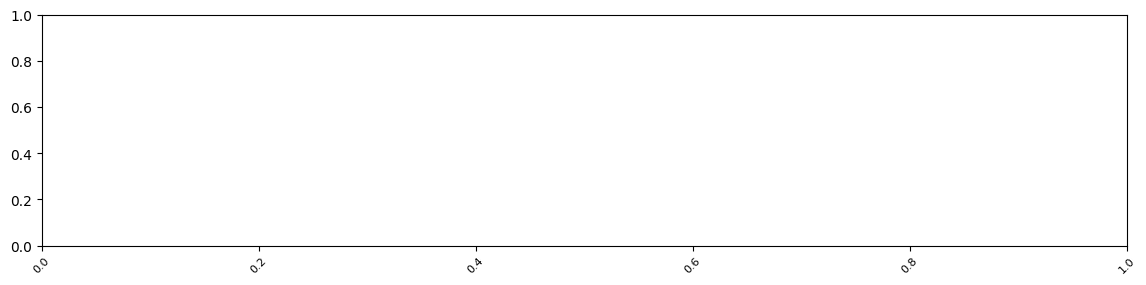

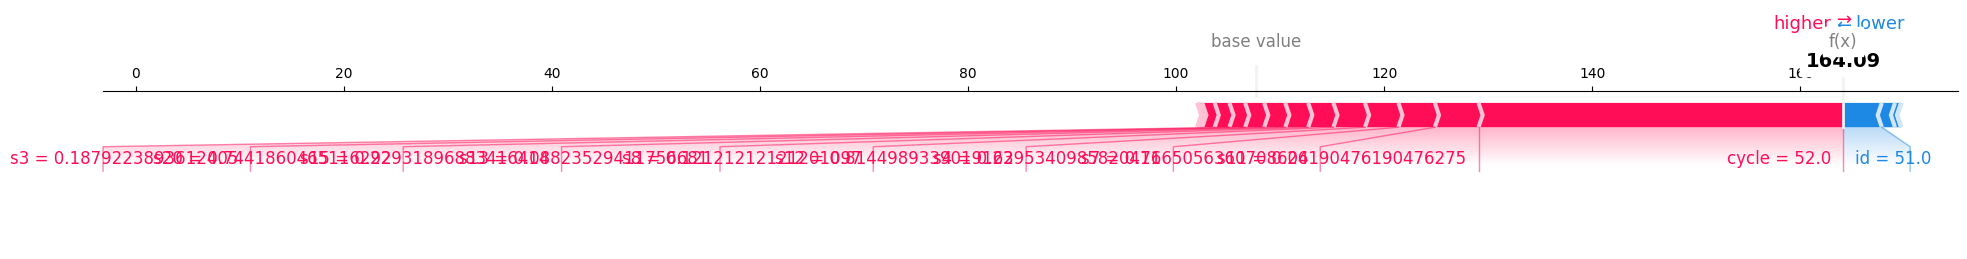

Computing SHAP (fast) for XGBoost...


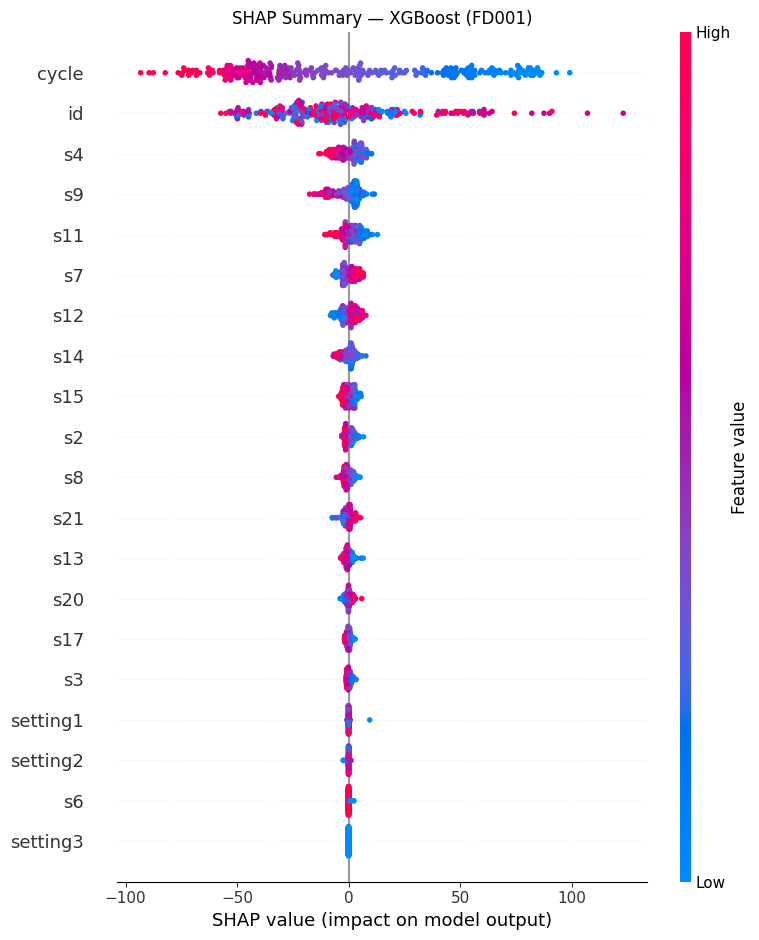

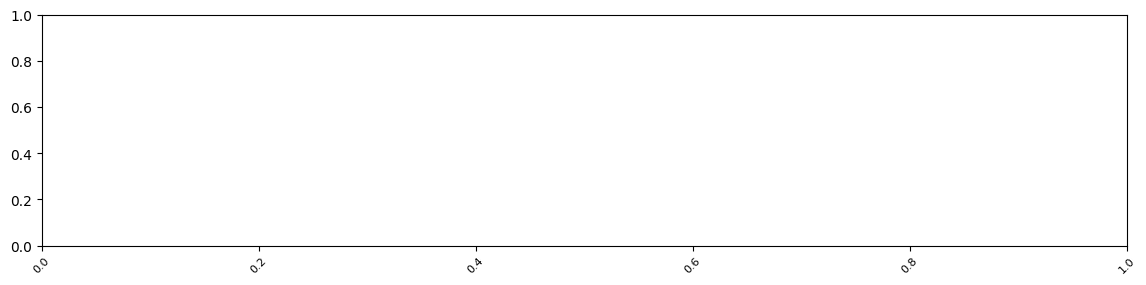

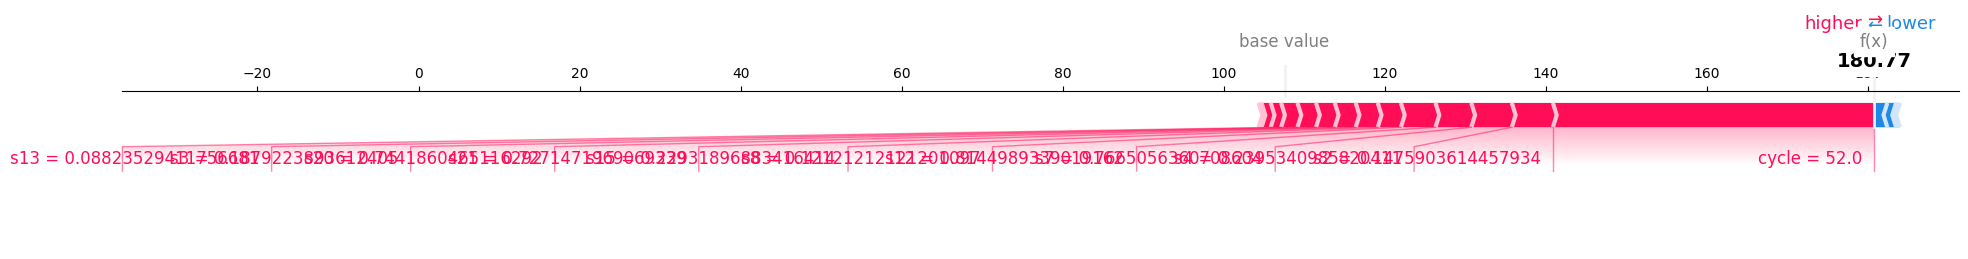

Plotting SHAP summary (Ensemble)...


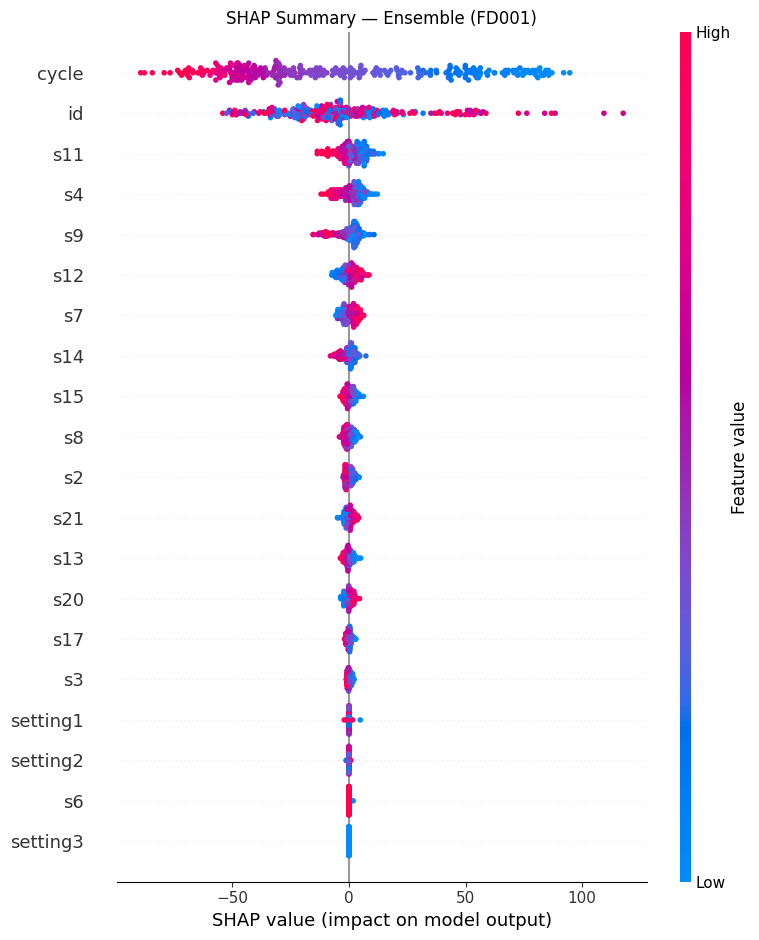

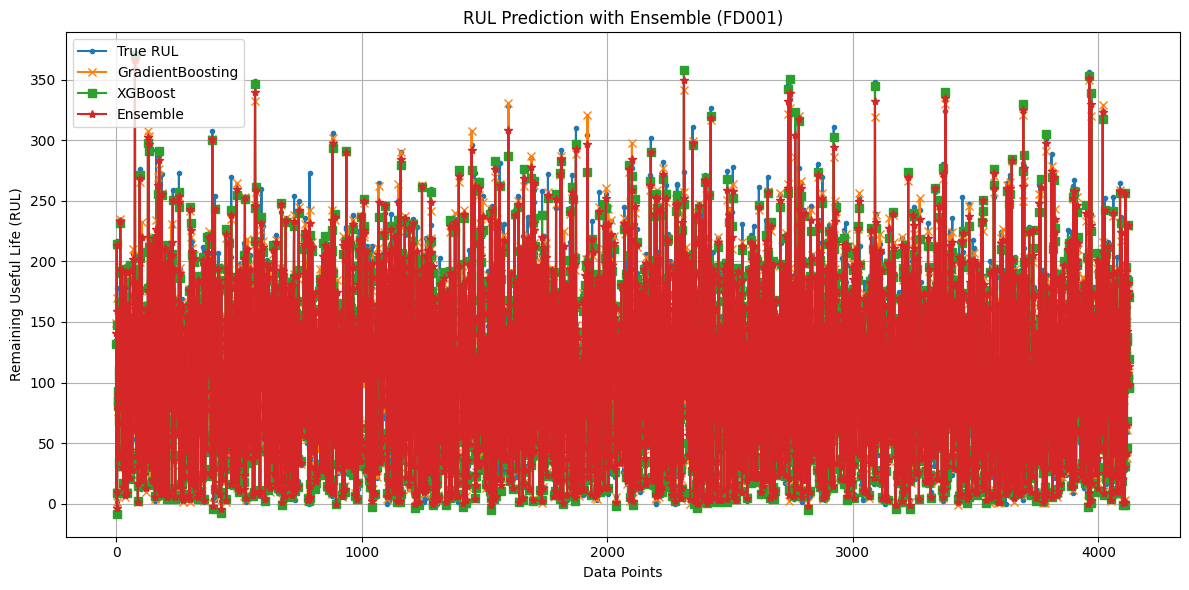



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.3028, RMSE=59.1113, MAE=38.1878, PHM08_sum=5161887702.1727, PHM08_avg=1252885.3646
Fold2: R2=0.4945, RMSE=49.2504, MAE=31.4115, PHM08_sum=226005980.8348, PHM08_avg=54683.2763
Fold3: R2=0.4821, RMSE=49.6187, MAE=33.6963, PHM08_sum=69874985.4030, PHM08_avg=16935.2849
Fold4: R2=0.5276, RMSE=46.7060, MAE=33.6000, PHM08_sum=71509452.0914, PHM08_avg=17335.6247
Fold5: R2=0.2890, RMSE=56.8091, MAE=38.9307, PHM08_sum=329004736564.5268, PHM08_avg=79720071.8596
Overall: R2=0.4187, RMSE=52.5150, MAE=35.1634, PHM08_sum=334534014685.0287, PHM08_avg=16215113.8910

--- GroupKFold (XGBoost) ---
Fold1: R2=0.4054, RMSE=54.5892, MAE=38.2528, PHM08_sum=6699229779.3160, PHM08_avg=1626026.6455
Fold2: R2=0.4055, RMSE=53.4097, MAE=36.9225, PHM

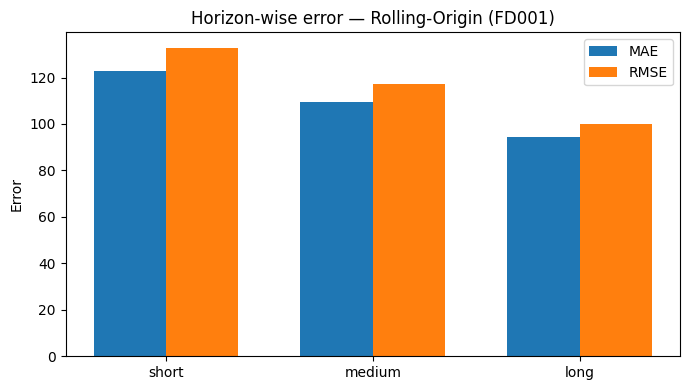

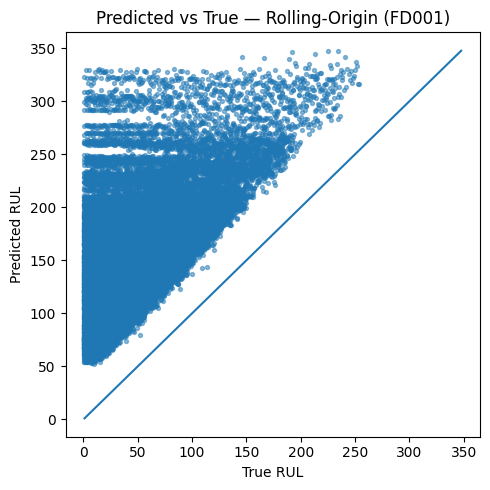


[PER-ENGINE MAE] (Top 10 worst engines)
69    163.926267
96    145.853432
92    143.977470
86    143.173510
67    142.323111
2     135.535121
64    132.587646
83    132.046724
17    131.070321
94    129.607911
dtype: float64


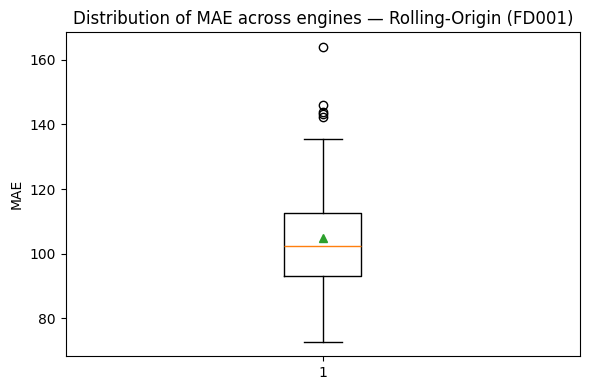

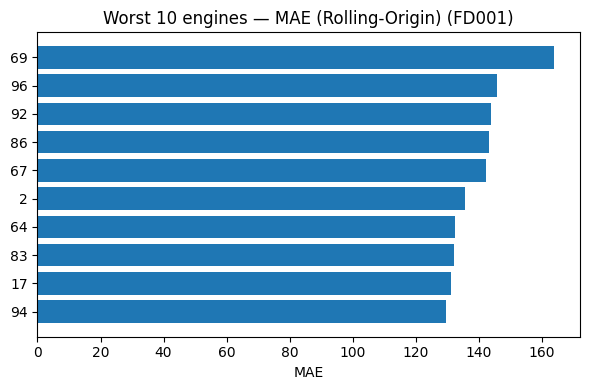


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.1752
    RMSE: 118.2440
     MAE: 109.6023
 sMAPE_%: 111.3669

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4175 ± 0.1778
Without id/cycle : R²=0.6070 ± 0.0495


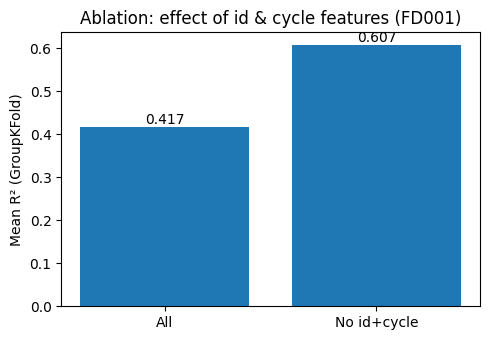


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 20631
Train (80%)   : 16504  → ratio=0.8000
Test  (20%)   : 4127  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 419.26 seconds
CPU% at start        : 12.4%   (~0.32 GHz)
CPU% at end          : 40.5%   (~1.05 GHz)
Memory at start      : 356.74 MB
Memory at end        : 466.91 MB   (Δ 110.17 MB)


In [2]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD001"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gb_xgb"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=4       # NOTE: keep 4 as requested
)

XGB_PARAMS = dict(
    objective="reg:squarederror",
    learning_rate=0.2,
    max_depth=4,
    n_estimators=200,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + XGB)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

xgb_model = XGBRegressor(**XGB_PARAMS)
xgb_model.fit(X_train, y_train)
y_xgb = xgb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_xgb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb  = print_block_metrics("GradientBoosting", y_val, y_gb)
m_xgb = print_block_metrics("XGBoost",          y_val, y_xgb)
m_ens = print_block_metrics("Ensemble",         y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_xgb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for XGBoost...")
shap_vals_xgb = tree_shap_fast(xgb_model, X_shap, "XGBoost", "XGBoost")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_xgb):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_xgb)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")
# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_xgb)),      y_xgb,          label="XGBoost",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_xgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", XGBRegressor(**XGB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb,  name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_xgb, name="XGBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_xgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, name="XGBoost"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; we keep it to demonstrate leakage differences
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_xgb, name="XGBoost")
_ = cv_eval_pipeline(X, y, groups, build_pipe_xgb(), name="XGBoost (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=0,  name=f"Rolling-Origin XGB (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=10, name=f"Rolling-Origin XGB (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_xgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_xgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



GradientBoosting Performance:
  R^2 Score:           0.9812
  Mean Squared Error:  88.4351
  Mean Absolute Error: 7.1405
  PHM08 Score (sum):   15060.0908
  PHM08 Score (avg):   1.4007

XGBoost Performance:
  R^2 Score:           0.9335
  Mean Squared Error:  312.2766
  Mean Absolute Error: 13.0481
  PHM08 Score (sum):   335032.3025
  PHM08 Score (avg):   31.1600

Ensemble Performance:
  R^2 Score:           0.9670
  Mean Squared Error:  154.9241
  Mean Absolute Error: 9.5175
  PHM08 Score (sum):   27006.5264
  PHM08 Score (avg):   2.5118
Computing SHAP (fast) for GradientBoosting...


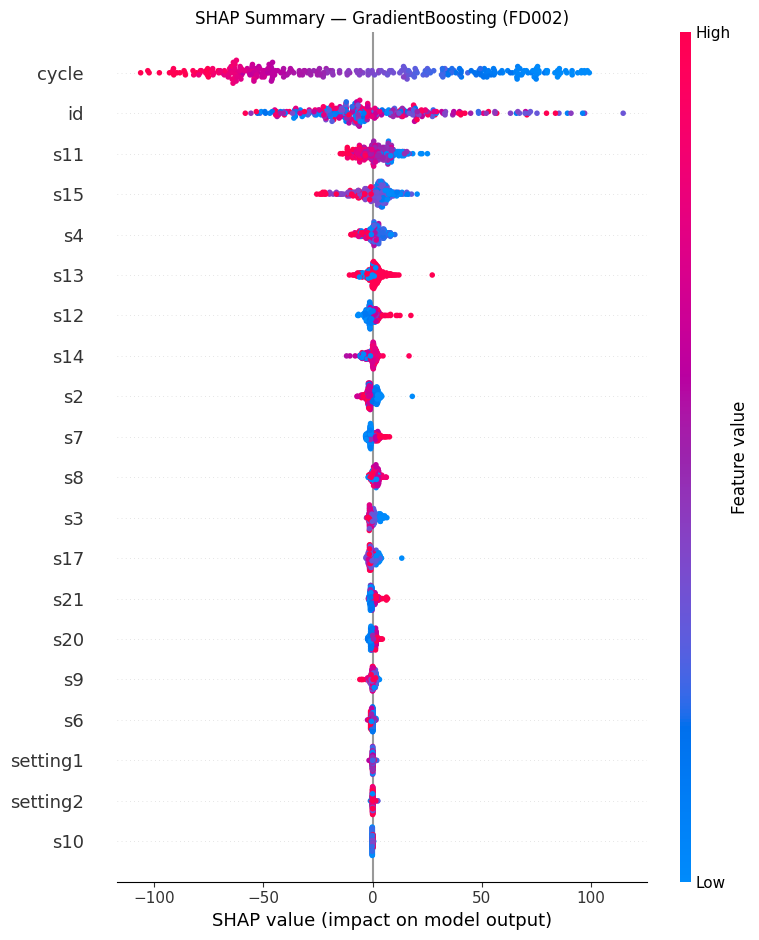

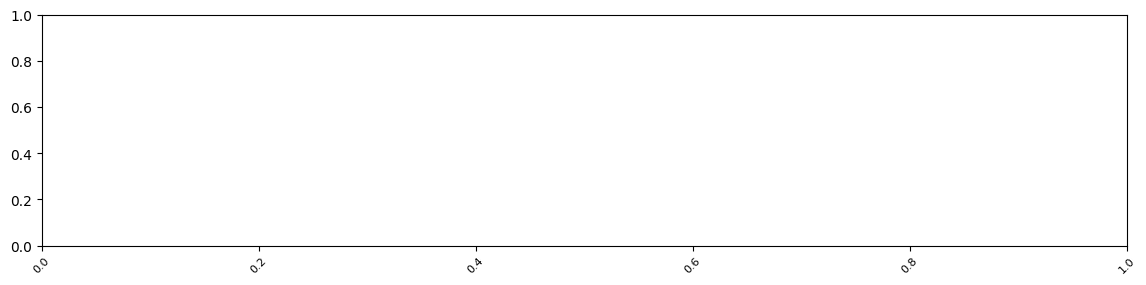

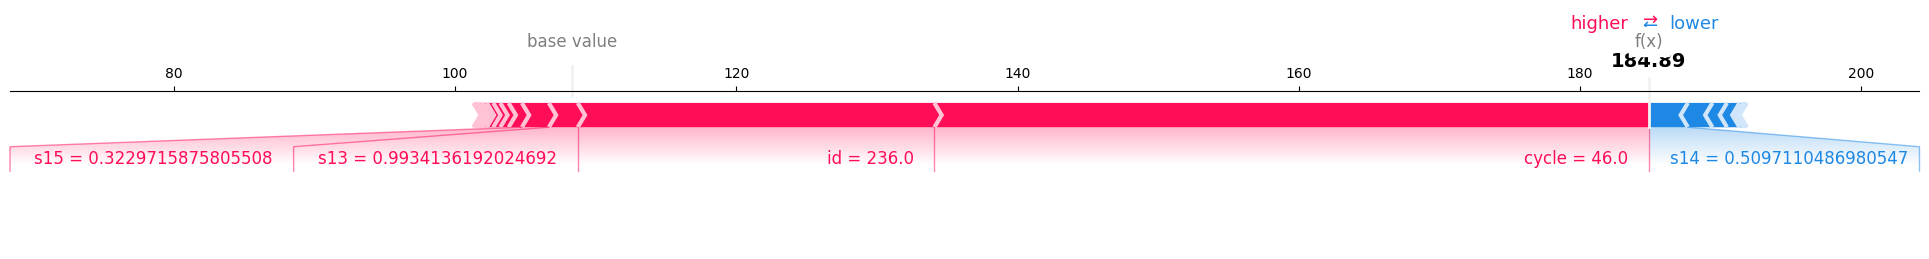

Computing SHAP (fast) for XGBoost...


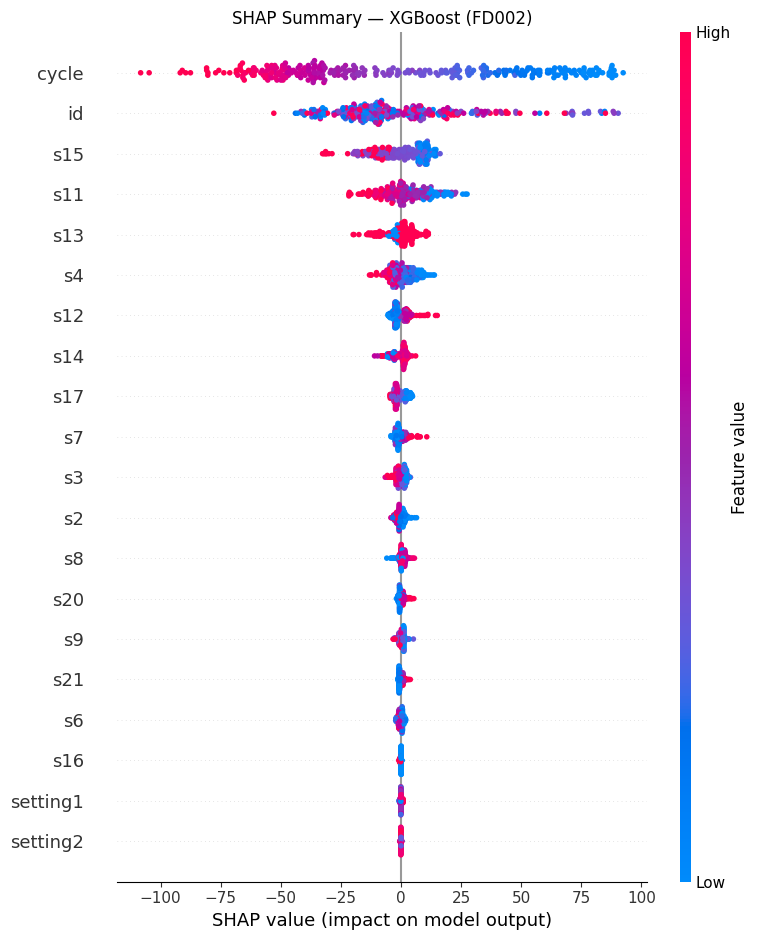

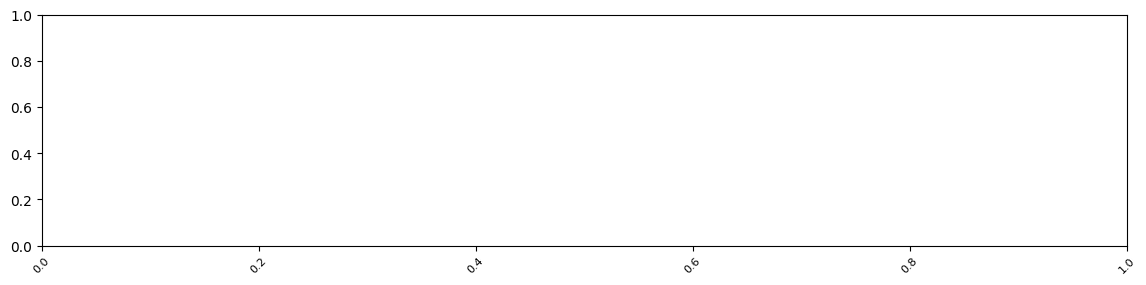

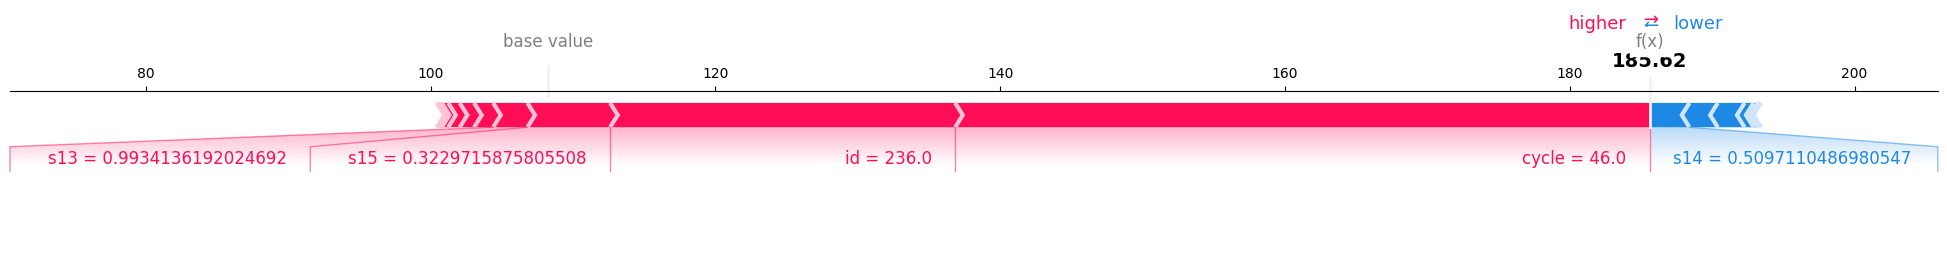

Plotting SHAP summary (Ensemble)...


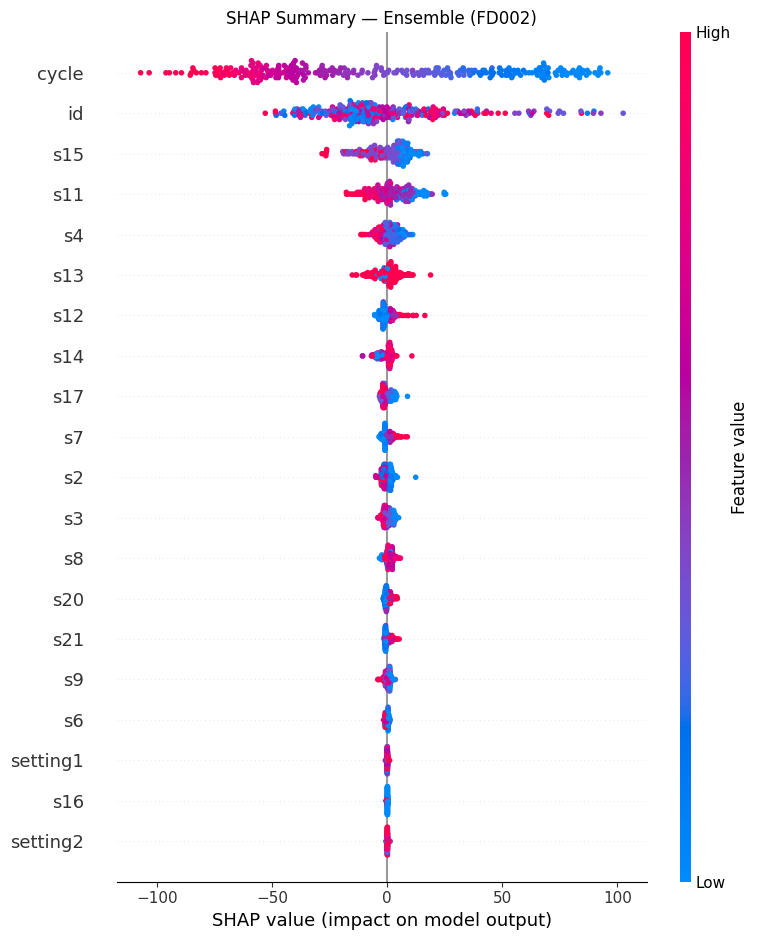

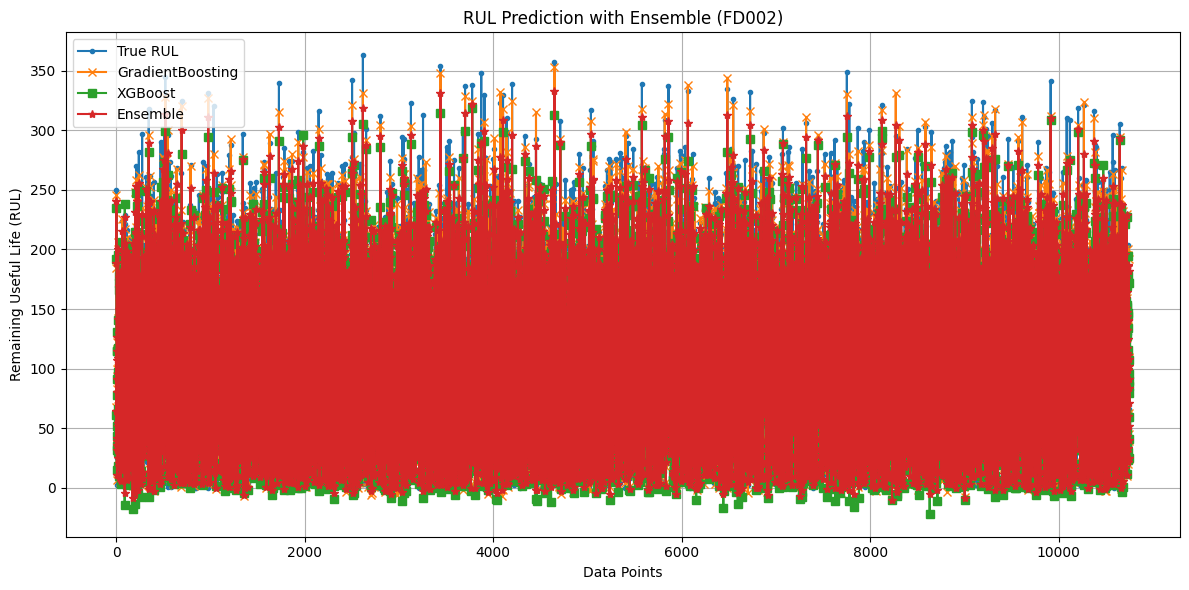



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.4727, RMSE=50.5361, MAE=38.9605, PHM08_sum=69971777.0317, PHM08_avg=6505.9765
Fold2: R2=0.4265, RMSE=52.4777, MAE=38.7034, PHM08_sum=3068163179.5360, PHM08_avg=285437.0806
Fold3: R2=0.6102, RMSE=43.0231, MAE=31.2757, PHM08_sum=9732794.7052, PHM08_avg=905.1237
Fold4: R2=0.4923, RMSE=49.1026, MAE=37.4739, PHM08_sum=49365799.4739, PHM08_avg=4590.8862
Fold5: R2=0.5545, RMSE=46.1744, MAE=33.5977, PHM08_sum=104559744.9920, PHM08_avg=9727.3928
Overall: R2=0.5110, RMSE=48.3775, MAE=36.0023, PHM08_sum=3301793295.7388, PHM08_avg=61418.4285

--- GroupKFold (XGBoost) ---
Fold1: R2=0.5262, RMSE=47.9050, MAE=36.8786, PHM08_sum=38475064.8008, PHM08_avg=3577.4119
Fold2: R2=0.4633, RMSE=50.7673, MAE=37.5897, PHM08_sum=1823965559.0549, 

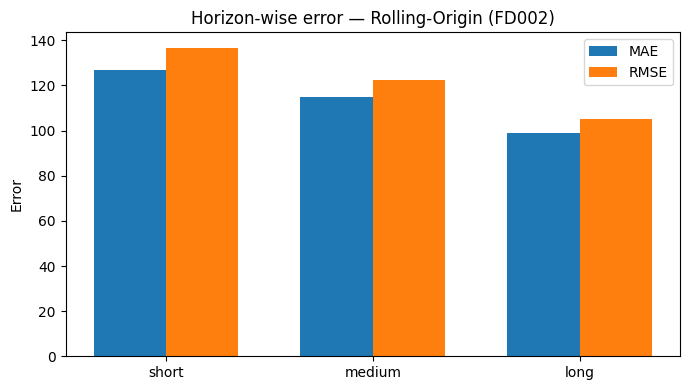

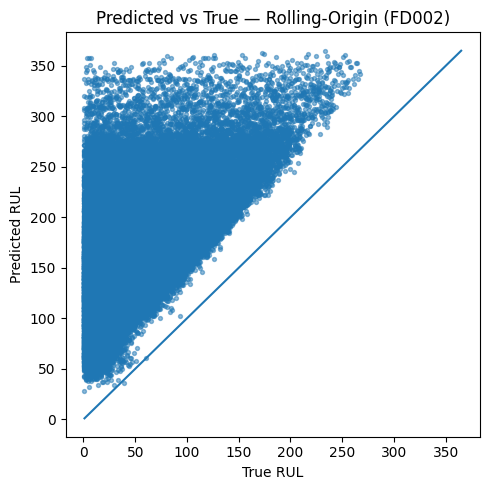


[PER-ENGINE MAE] (Top 10 worst engines)
112    174.120857
85     165.735490
88     162.915186
255    161.203412
31     158.286609
118    157.016648
260    146.548090
94     142.721915
239    142.057234
158    142.015211
dtype: float64


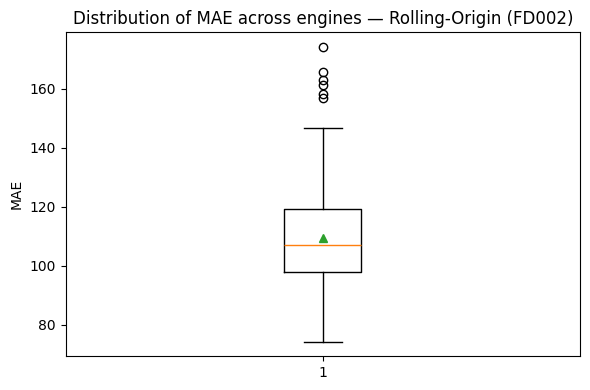

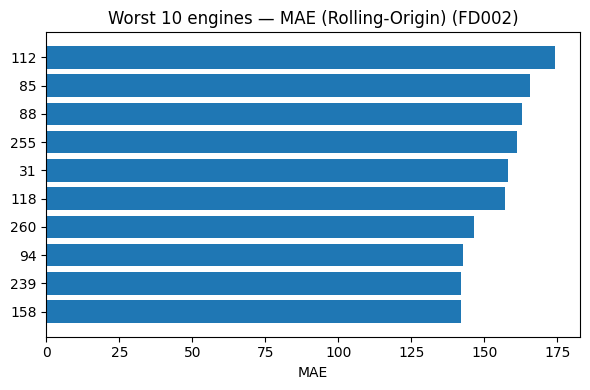


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.7394
    RMSE: 122.8946
     MAE: 114.4123
 sMAPE_%: 113.1224

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.5220 ± 0.0496
Without id/cycle : R²=0.5927 ± 0.0344


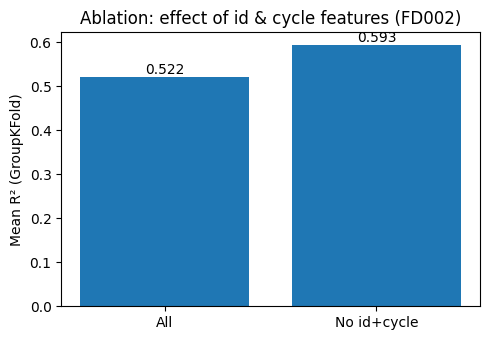


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 53759
Train (80%)   : 43007  → ratio=0.8000
Test  (20%)   : 10752  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1296.54 seconds
CPU% at start        : 2.7%   (~0.07 GHz)
CPU% at end          : 36.2%   (~0.94 GHz)
Memory at start      : 467.42 MB
Memory at end        : 584.82 MB   (Δ 117.39 MB)


In [3]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD002"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gb_xgb"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=4       # NOTE: keep 4 as requested
)

XGB_PARAMS = dict(
    objective="reg:squarederror",
    learning_rate=0.2,
    max_depth=4,
    n_estimators=200,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + XGB)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

xgb_model = XGBRegressor(**XGB_PARAMS)
xgb_model.fit(X_train, y_train)
y_xgb = xgb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_xgb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb  = print_block_metrics("GradientBoosting", y_val, y_gb)
m_xgb = print_block_metrics("XGBoost",          y_val, y_xgb)
m_ens = print_block_metrics("Ensemble",         y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_xgb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for XGBoost...")
shap_vals_xgb = tree_shap_fast(xgb_model, X_shap, "XGBoost", "XGBoost")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_xgb):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_xgb)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")
# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_xgb)),      y_xgb,          label="XGBoost",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_xgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", XGBRegressor(**XGB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb,  name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_xgb, name="XGBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_xgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, name="XGBoost"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; we keep it to demonstrate leakage differences
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_xgb, name="XGBoost")
_ = cv_eval_pipeline(X, y, groups, build_pipe_xgb(), name="XGBoost (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=0,  name=f"Rolling-Origin XGB (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=10, name=f"Rolling-Origin XGB (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_xgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_xgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



GradientBoosting Performance:
  R^2 Score:           0.9864
  Mean Squared Error:  132.9293
  Mean Absolute Error: 7.7740
  PHM08 Score (sum):   23149.8136
  PHM08 Score (avg):   4.6824

XGBoost Performance:
  R^2 Score:           0.9779
  Mean Squared Error:  216.6679
  Mean Absolute Error: 10.6474
  PHM08 Score (sum):   27351.4890
  PHM08 Score (avg):   5.5323

Ensemble Performance:
  R^2 Score:           0.9860
  Mean Squared Error:  137.1641
  Mean Absolute Error: 8.1880
  PHM08 Score (sum):   15316.3290
  PHM08 Score (avg):   3.0980
Computing SHAP (fast) for GradientBoosting...


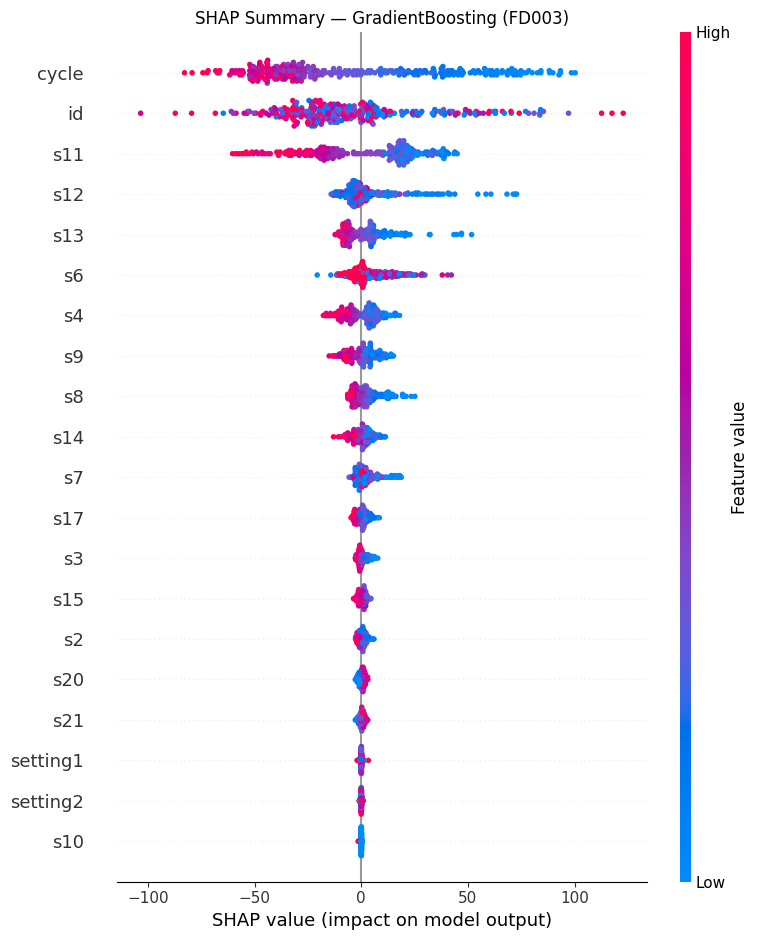

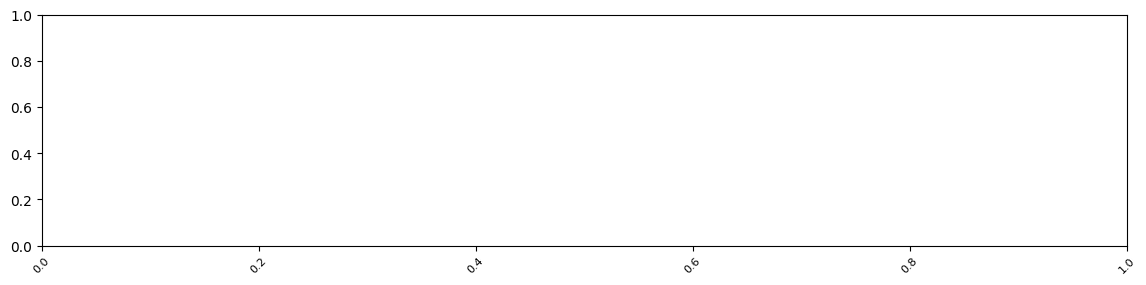

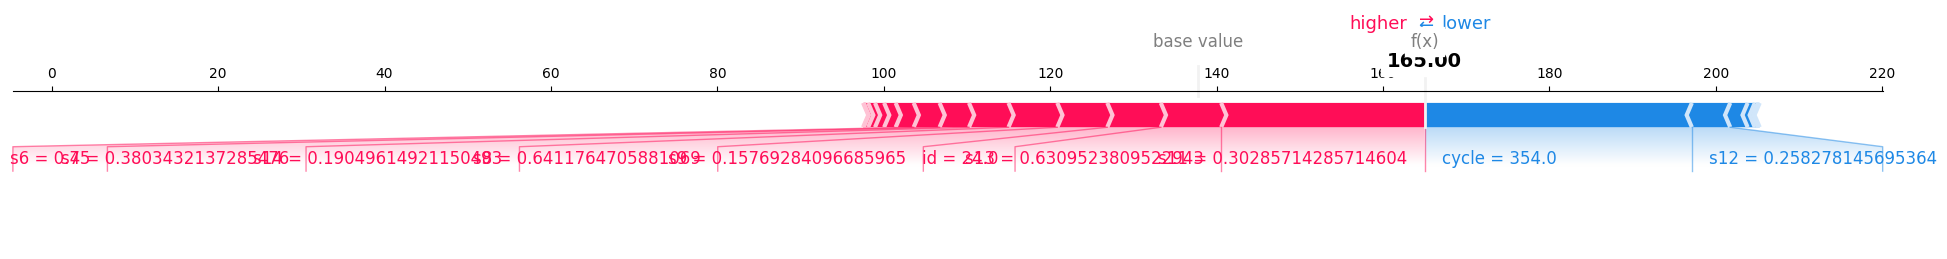

Computing SHAP (fast) for XGBoost...


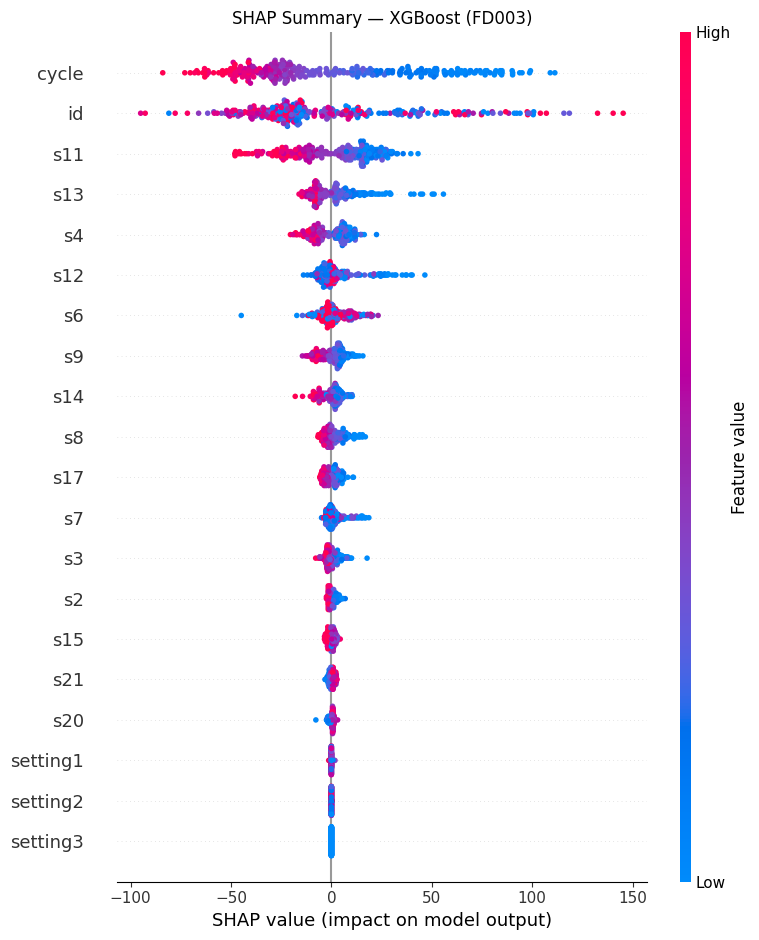

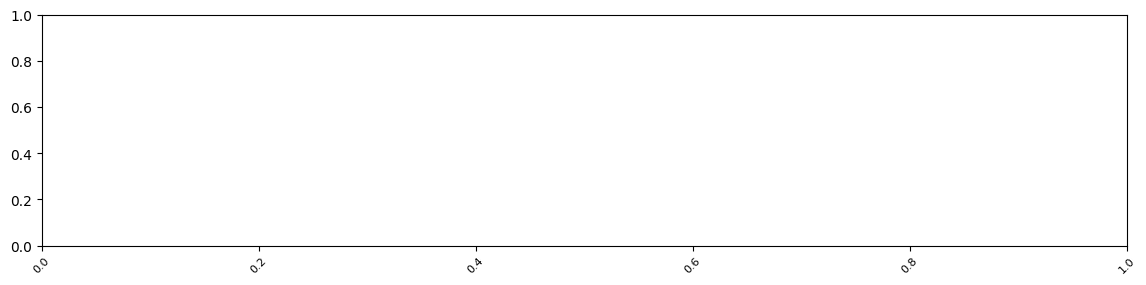

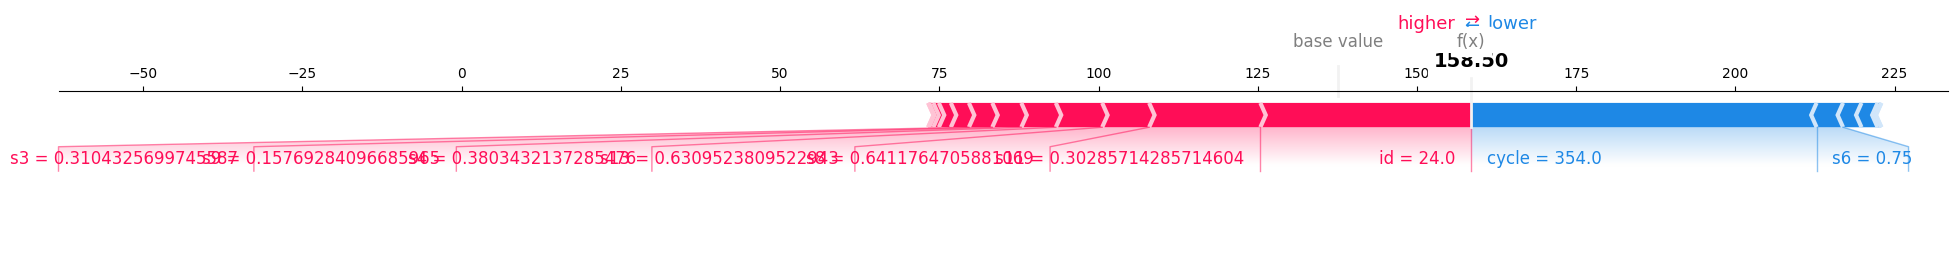

Plotting SHAP summary (Ensemble)...


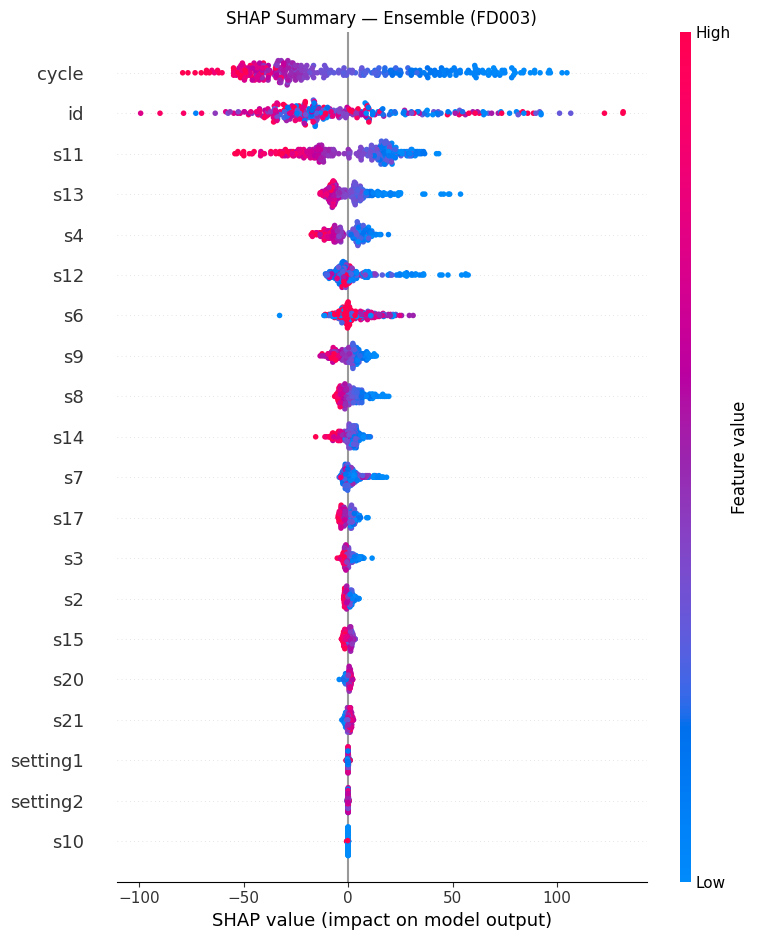

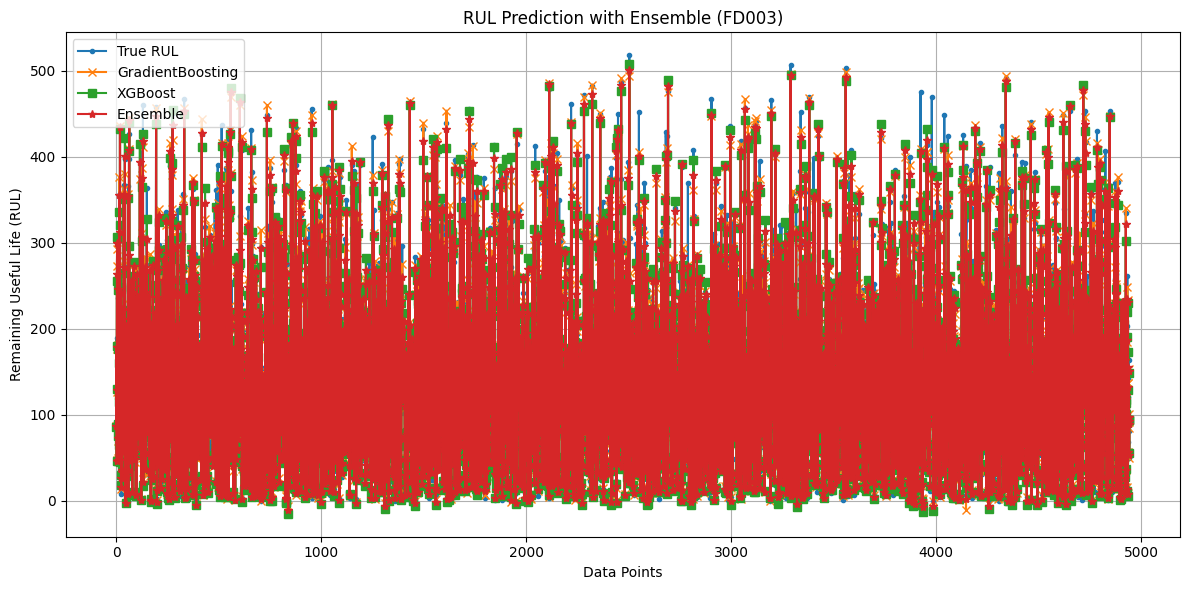



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.2686, RMSE=86.6443, MAE=55.1681, PHM08_sum=5876527105708.7832, PHM08_avg=1189098969.1843
Fold2: R2=0.5910, RMSE=63.0893, MAE=43.3446, PHM08_sum=19788239532.3838, PHM08_avg=4000857.1638
Fold3: R2=0.3049, RMSE=81.9917, MAE=56.6193, PHM08_sum=56178222427218.2188, PHM08_avg=11358314279.6640
Fold4: R2=0.2260, RMSE=86.3471, MAE=54.8035, PHM08_sum=647098686721.7594, PHM08_avg=130991636.9882
Fold5: R2=0.4160, RMSE=74.6806, MAE=52.7402, PHM08_sum=28028191585.3796, PHM08_avg=5666840.1911
Overall: R2=0.3605, RMSE=79.0451, MAE=52.5342, PHM08_sum=62749664650766.5312, PHM08_avg=2538416854.8045

--- GroupKFold (XGBoost) ---
Fold1: R2=0.4138, RMSE=77.5680, MAE=56.5351, PHM08_sum=383510875593.7645, PHM08_avg=77602362.5240
Fold2: R2=0.5

KeyboardInterrupt: 

In [5]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD003"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gb_xgb"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=4       # NOTE: keep 4 as requested
)

XGB_PARAMS = dict(
    objective="reg:squarederror",
    learning_rate=0.2,
    max_depth=4,
    n_estimators=200,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + XGB)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

xgb_model = XGBRegressor(**XGB_PARAMS)
xgb_model.fit(X_train, y_train)
y_xgb = xgb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_xgb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb  = print_block_metrics("GradientBoosting", y_val, y_gb)
m_xgb = print_block_metrics("XGBoost",          y_val, y_xgb)
m_ens = print_block_metrics("Ensemble",         y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_xgb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for XGBoost...")
shap_vals_xgb = tree_shap_fast(xgb_model, X_shap, "XGBoost", "XGBoost")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_xgb):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_xgb)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")
# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_xgb)),      y_xgb,          label="XGBoost",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_xgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", XGBRegressor(**XGB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb,  name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_xgb, name="XGBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_xgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, name="XGBoost"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; we keep it to demonstrate leakage differences
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_xgb, name="XGBoost")
_ = cv_eval_pipeline(X, y, groups, build_pipe_xgb(), name="XGBoost (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=0,  name=f"Rolling-Origin XGB (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=10, name=f"Rolling-Origin XGB (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_xgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_xgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



GradientBoosting Performance:
  R^2 Score:           0.9754
  Mean Squared Error:  197.4931
  Mean Absolute Error: 10.4501
  PHM08 Score (sum):   55092.3938
  PHM08 Score (avg):   4.4973

XGBoost Performance:
  R^2 Score:           0.9449
  Mean Squared Error:  442.6934
  Mean Absolute Error: 16.1760
  PHM08 Score (sum):   145513.5241
  PHM08 Score (avg):   11.8787

Ensemble Performance:
  R^2 Score:           0.9667
  Mean Squared Error:  267.6271
  Mean Absolute Error: 12.4561
  PHM08 Score (sum):   62497.7812
  PHM08 Score (avg):   5.1019
Computing SHAP (fast) for GradientBoosting...


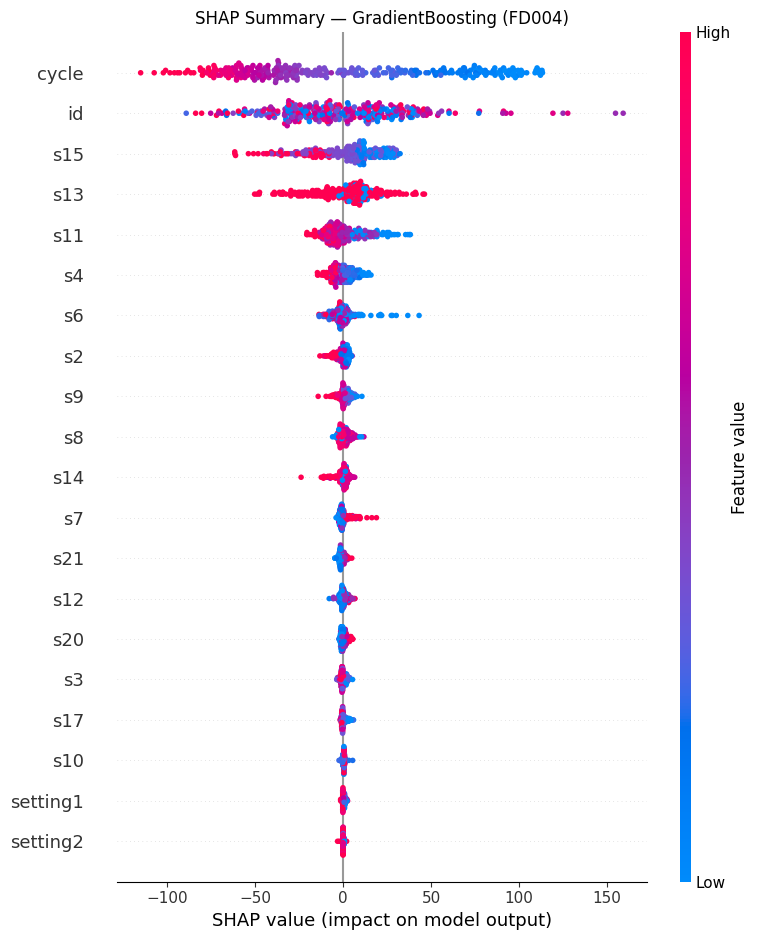

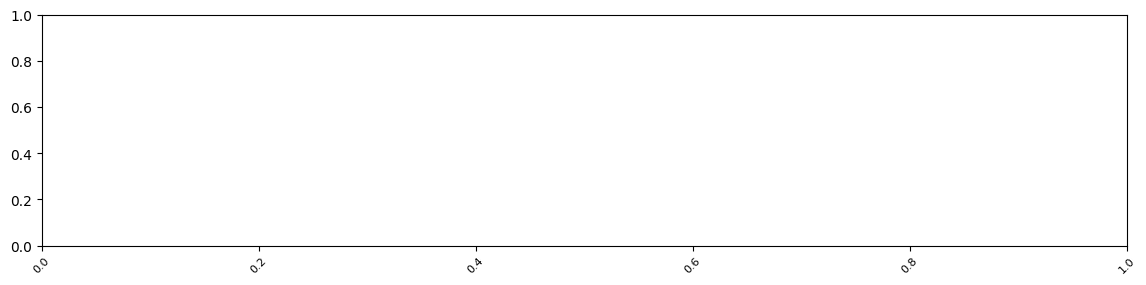

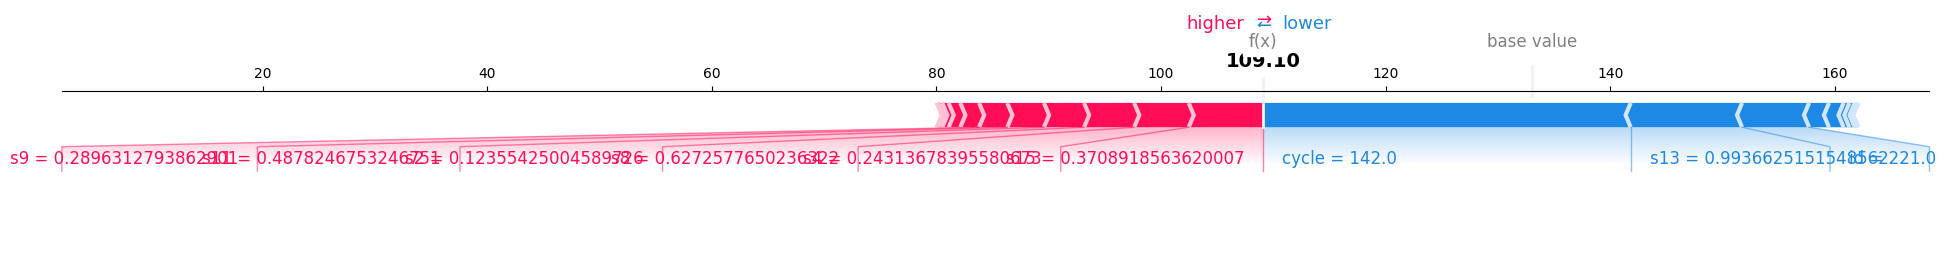

Computing SHAP (fast) for XGBoost...


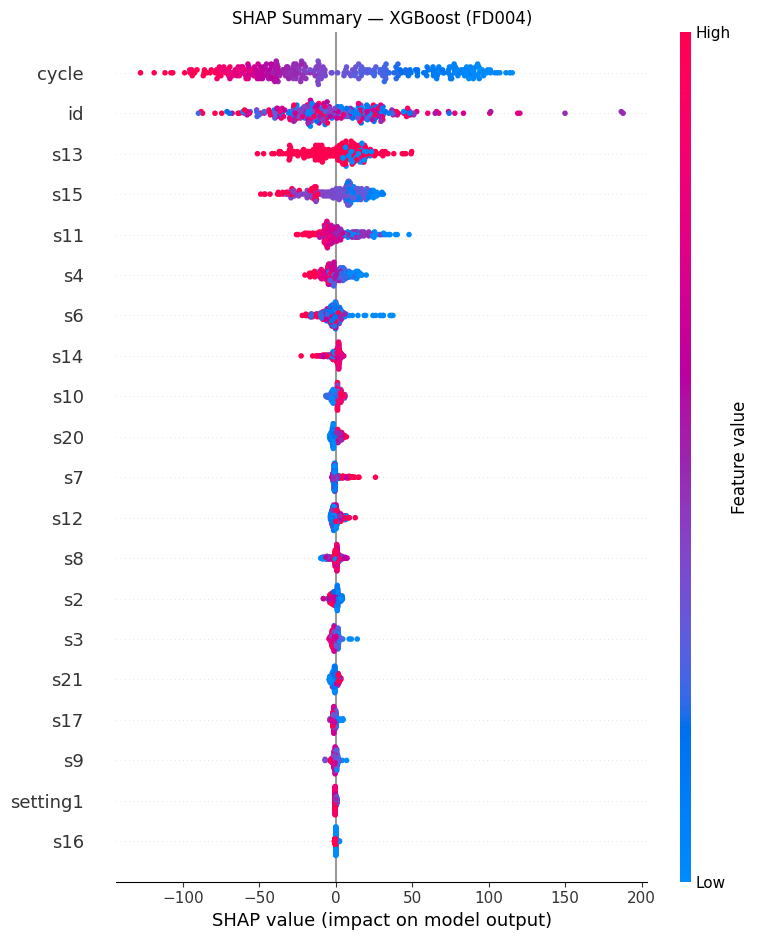

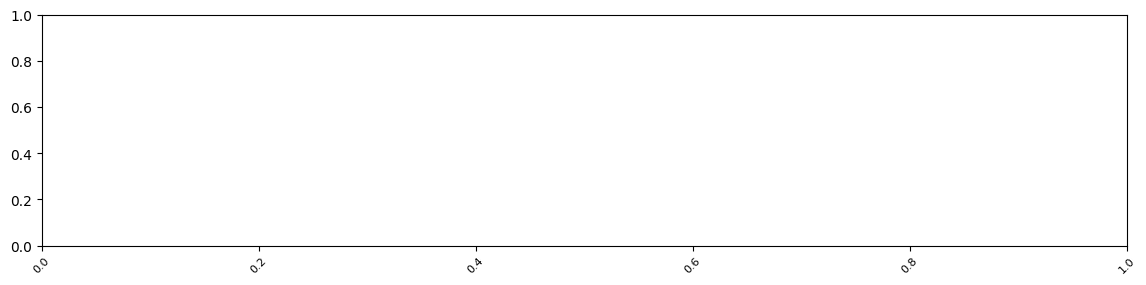

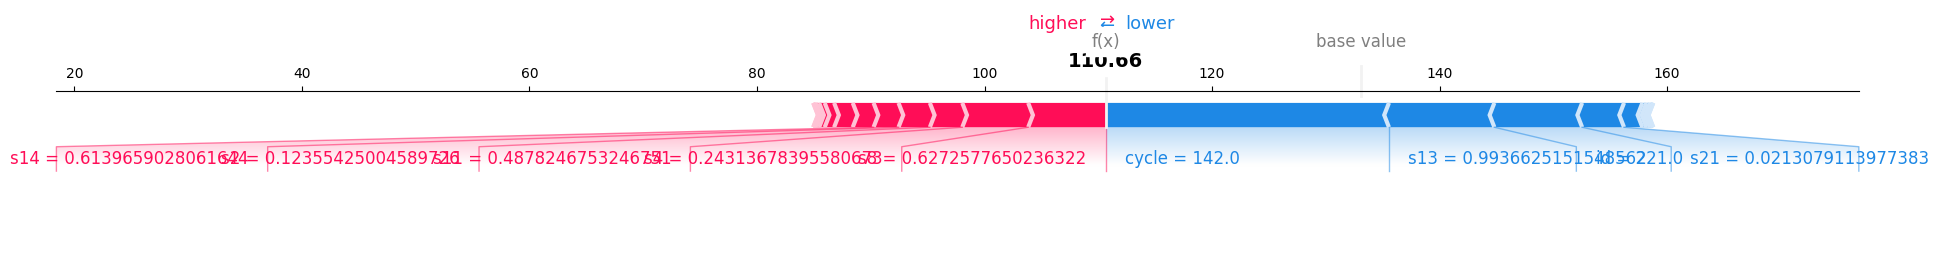

Plotting SHAP summary (Ensemble)...


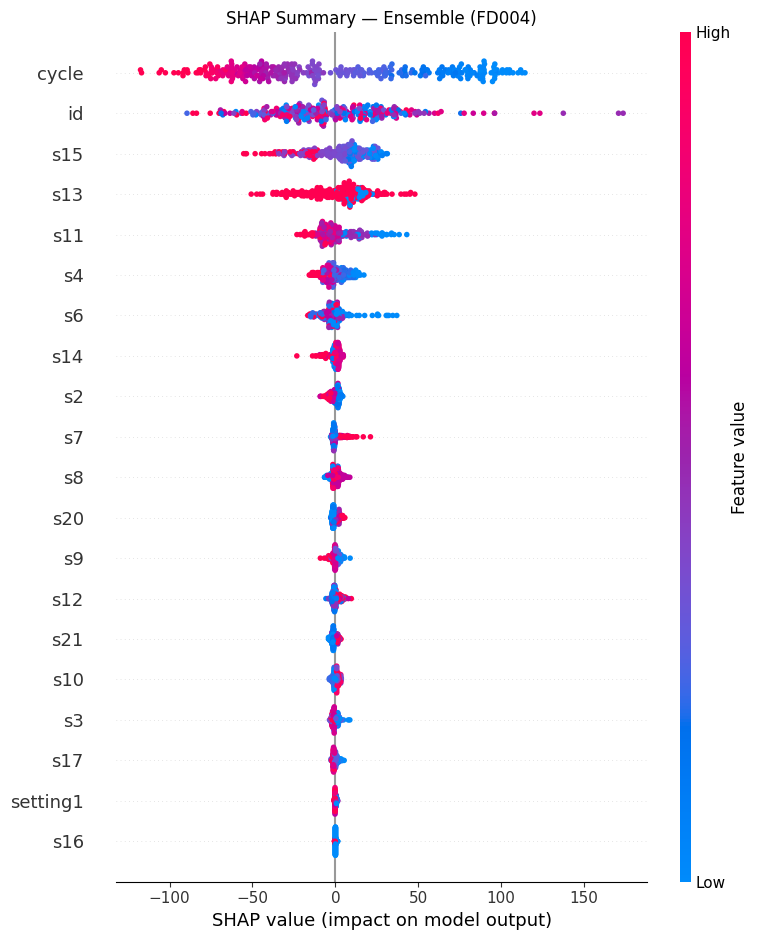

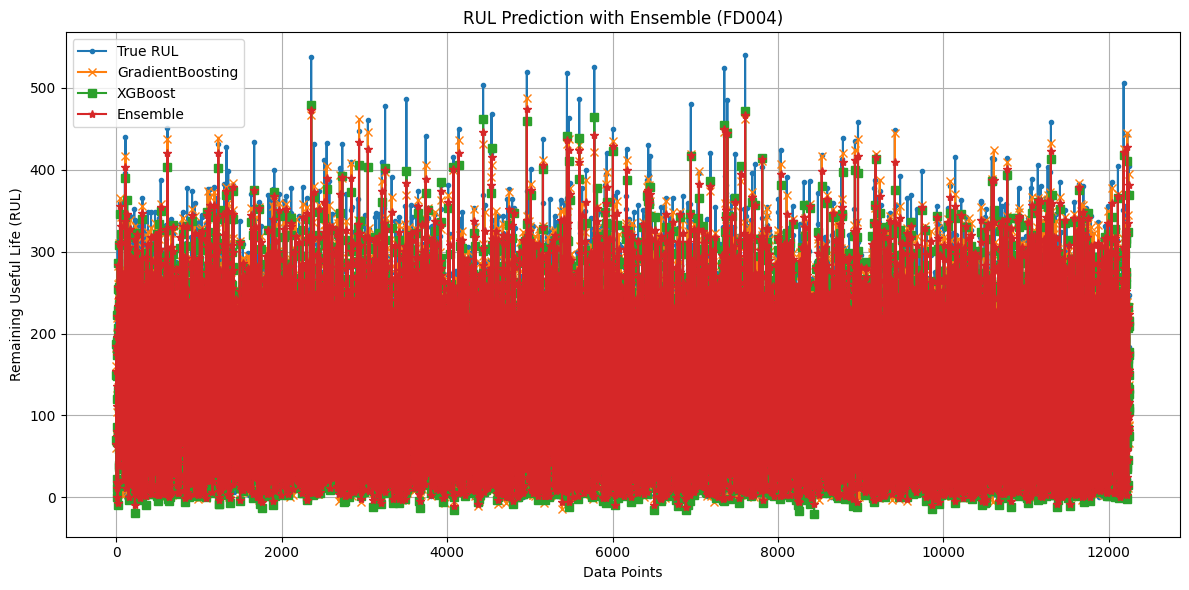



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (GradientBoosting) ---
Fold1: R2=0.3127, RMSE=76.9012, MAE=55.7665, PHM08_sum=92617399133.2131, PHM08_avg=7542133.4799
Fold2: R2=0.3309, RMSE=73.5547, MAE=52.2447, PHM08_sum=198200975680959.4062, PHM08_avg=16318209754.7307
Fold3: R2=0.5890, RMSE=56.9903, MAE=41.0849, PHM08_sum=6931009940.7752, PHM08_avg=564736.4084
Fold4: R2=0.5819, RMSE=57.3159, MAE=41.5454, PHM08_sum=182958467084.5712, PHM08_avg=14906181.1214
Fold5: R2=0.6178, RMSE=54.7818, MAE=41.1179, PHM08_sum=2615362652.5116, PHM08_avg=213046.8111
Overall: R2=0.4828, RMSE=64.5692, MAE=46.3404, PHM08_sum=198486097919770.4375, PHM08_avg=3240642262.2373

--- GroupKFold (XGBoost) ---
Fold1: R2=0.4033, RMSE=71.6566, MAE=52.6707, PHM08_sum=18226075820.9975, PHM08_avg=1484208.1287
Fold2: R2=0.2148, RMSE=

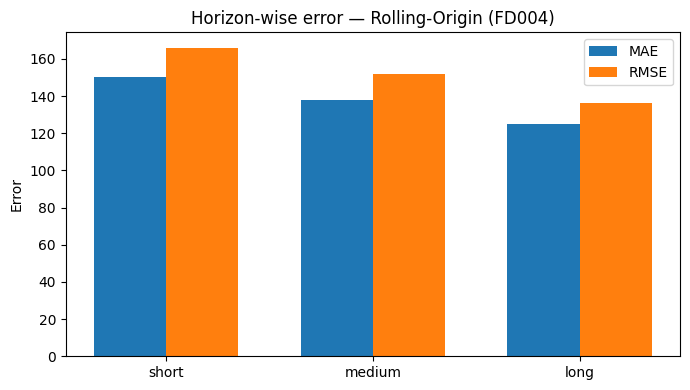

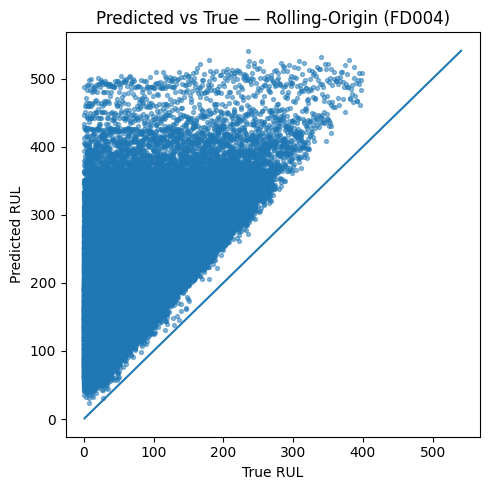


[PER-ENGINE MAE] (Top 10 worst engines)
118    243.957641
133    226.838194
173    206.988083
225    203.716775
49     202.606275
179    201.045064
171    189.960622
131    187.991445
37     185.880002
158    182.949037
dtype: float64


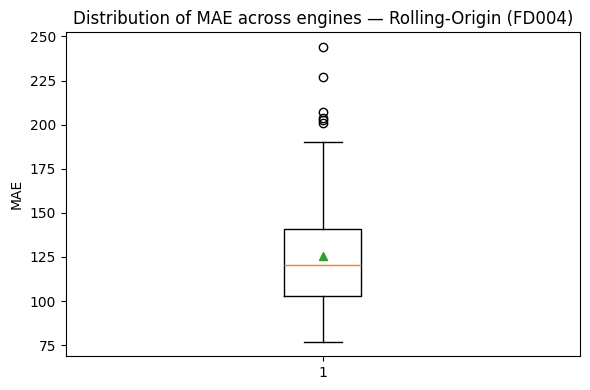

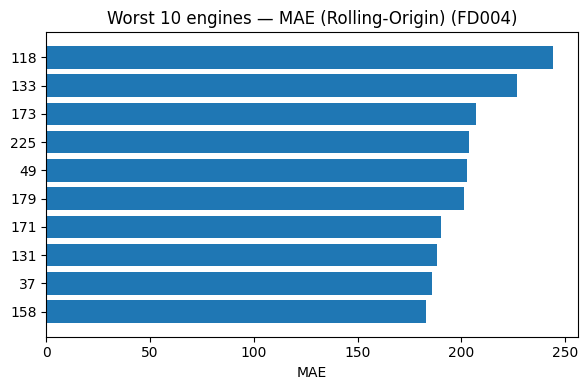


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -6.1204
    RMSE: 149.9926
     MAE: 136.0974
 sMAPE_%: 109.4172

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.4597 ± 0.1370
Without id/cycle : R²=0.5953 ± 0.0395


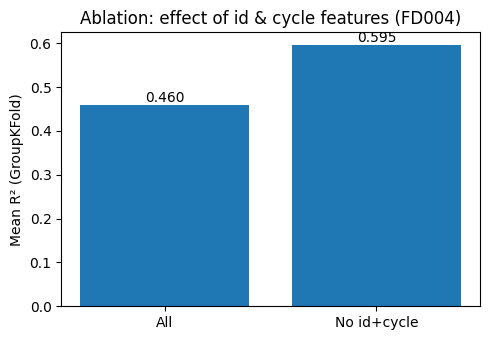


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1433.07 seconds
CPU% at start        : 26.9%   (~0.70 GHz)
CPU% at end          : 35.7%   (~0.93 GHz)
Memory at start      : 302.62 MB
Memory at end        : 546.62 MB   (Δ 244.00 MB)


In [1]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "gb_xgb"

# Fixed model hyperparameters (as requested)
GB_PARAMS = dict(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    random_state=4       # NOTE: keep 4 as requested
)

XGB_PARAMS = dict(
    objective="reg:squarederror",
    learning_rate=0.2,
    max_depth=4,
    n_estimators=200,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (GB + XGB)
# ============================================
gb_model = GradientBoostingRegressor(**GB_PARAMS)
gb_model.fit(X_train, y_train)
y_gb = gb_model.predict(X_val)

xgb_model = XGBRegressor(**XGB_PARAMS)
xgb_model.fit(X_train, y_train)
y_xgb = xgb_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_gb + 0.5 * y_xgb

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_gb  = print_block_metrics("GradientBoosting", y_val, y_gb)
m_xgb = print_block_metrics("XGBoost",          y_val, y_xgb)
m_ens = print_block_metrics("Ensemble",         y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_gb, m_xgb, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations (TreeExplainer for tree models)
# ============================================
SHAP_SAMPLES = min(300, X_val.shape[0])  # small subset for speed
X_shap = X_val.sample(n=SHAP_SAMPLES, random_state=42)

def tree_shap_fast(model, X_explain_df, title_prefix, file_tag):
    # Fast TreeExplainer settings for tree models
    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent",
        model_output="raw"
    )
    # Skip additivity check for speed
    shap_vals = explainer.shap_values(X_explain_df, check_additivity=False)

    # Summary plot (saved)
    shap.summary_plot(shap_vals, X_explain_df, show=False)
    plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
    plt.show()

    # Single-row force plot (saved)
    row = X_explain_df.iloc[[0]]
    sv_row = np.asarray(explainer.shap_values(row, check_additivity=False))[0]
    expected_val = float(np.asarray(explainer.expected_value).mean())
    fig, ax = plt.subplots(figsize=(14, 3))
    _ = shap.force_plot(expected_val, sv_row, row.iloc[0].values,
                        feature_names=row.columns.tolist(), matplotlib=True, show=False)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    plt.tight_layout()
    save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
    plt.show()

    return shap_vals

print("Computing SHAP (fast) for GradientBoosting...")
shap_vals_gb = tree_shap_fast(gb_model, X_shap, "GradientBoosting", "GradientBoosting")

print("Computing SHAP (fast) for XGBoost...")
shap_vals_xgb = tree_shap_fast(xgb_model, X_shap, "XGBoost", "XGBoost")

# Ensemble SHAP (only if shapes match)
if np.shape(shap_vals_gb) == np.shape(shap_vals_xgb):
    shap_vals_ens = (np.asarray(shap_vals_gb) + np.asarray(shap_vals_xgb)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (shape mismatch).")
# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_gb)),       y_gb,           label="GradientBoosting",  marker='x')
plt.plot(range(len(y_xgb)),      y_xgb,          label="XGBoost",           marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",          marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

import warnings
warnings.filterwarnings("ignore")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_gb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", GradientBoostingRegressor(**GB_PARAMS))
])
pipe_xgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", XGBRegressor(**XGB_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_gb,  name="GradientBoosting")
_ = cv_eval_pipeline(X, y, groups, pipe_xgb, name="XGBoost")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_gb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", GradientBoostingRegressor(**GB_PARAMS))
    ])

def build_pipe_xgb():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_gb, name="GradientBoosting"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, name="XGBoost"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    # For tree models, scaling is usually irrelevant; we keep it to demonstrate leakage differences
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", XGBRegressor(**XGB_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_xgb, name="XGBoost")
_ = cv_eval_pipeline(X, y, groups, build_pipe_xgb(), name="XGBoost (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=0,  name=f"Rolling-Origin XGB (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb,
    embargo_val=10, name=f"Rolling-Origin XGB (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_xgb
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_xgb)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_xgb)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")
